In [1]:
# !pip install catboost
# !pip install shap

In [2]:
import warnings
warnings.filterwarnings("ignore")

import base64
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import cross_val_score, LeaveOneOut

from catboost import CatBoostRegressor, CatBoostClassifier

import shap
import folium
from folium.plugins import MarkerCluster, HeatMap
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 60)

SEED = 42

In [3]:
def get_dif(largest_iso, least_iso):
  for col in ['bus_stop', 'house', 'kiosk',
        'retail', 'station', 'subway_entrance', 'tram_stop', 'bar', 'cafe',
        'fast_food', 'food_court', 'pub', 'restaurant', 'college',
        'driving_school', 'language_school', 'school', 'kindergarten',
        'university', 'car_wash', 'fuel', 'atm', 'bank', 'clinic', 'dentist',
        'doctors', 'hospital', 'pharmacy', 'veterinary', 'theatre', 'cinema',
        'hostel', 'hotel', 'office', 'shop']:
    largest_iso[col] = largest_iso[col]-least_iso[col]


def add_weights(columns, weight):
  for col_name in scaled_data.columns:
    if columns in col_name:
      scaled_data[col_name] = scaled_data[col_name]*weight


def make_classes_for_num_checks(q):
  df_target['interval'] = pd.qcut(df_target["Чеки шт/мес"], q=q)
  df_target['makr_class'] = pd.qcut(df_target["Чеки шт/мес"], q=q, labels=False)

  for i in range(q):
    df_target.loc[df_target['makr_class'] == i, 'mean'] = df_target[df_target['makr_class'] == i]["Чеки шт/мес"].mean()

In [4]:
df_target = pd.read_csv('../../data/vkusvill_target.csv')
data = pd.read_csv('../../data/vkusvill_data_without_target.csv')
iso_30 = pd.read_csv('../../data/vkusvill_isochrone_30.csv')
iso_25 = pd.read_csv('../../data/vkusvill_isochrone_25.csv')
iso_20 = pd.read_csv('../../data/vkusvill_isochrone_20.csv')
iso_15 = pd.read_csv('../../data/vkusvill_isochrone_15.csv')
iso_10 = pd.read_csv('../../data/vkusvill_isochrone_10.csv')
dist_df = pd.read_csv('../../data/vkusvill_dist.csv')
highway_df = pd.read_csv('../../data/vkusvill_highway.csv')
highway_df.drop(['name_highway', 'Номерточки'], axis=1, inplace=True)
reestrmkd_df = pd.read_csv('../../data/vkusvill_reestrmkd.csv')
reestrmkd_df.drop(['Номерточки'], axis=1, inplace=True)

info = data.copy()

get_dif(iso_30, iso_25)
get_dif(iso_25, iso_20)
get_dif(iso_20, iso_15)
get_dif(iso_15, iso_10)

# revenue = df_target['Выручка р/мес'].values
# avg_check = df_target["Выручка р/мес"] / df_target["Чеки шт/мес"]
# num_checks = df_target["Чеки шт/мес"].values

In [5]:
work_schedule = [
    ['с 9-00 до 22-00', 9, 22, 9, 22, 0], 
    ['с 8-00 до 22-00', 8, 22, 8, 22, 0],
    ['пн-чт с 7-00 - 23-45, пт-сб с 8-00 - 23-00, вс с 7-00 - 23-45', 7, 23, 7, 23, 1],
    ['Откл. с 9:00 до 22:00', 9, 22, 9, 22, 0], 
    ['с 7-00 до 22-00', 7, 22, 7, 22, 0],
    ['будни с 8-00 до 22-00; вых. с 9-00 до 22-00', 8, 22, 9, 22, 1], 
    ['с 10-00 до 22-00', 10, 22, 10, 22, 0],
    ['будни с 9-00 до 23-00, выходные с 9-00 до 22-00', 9, 23, 9, 22, 1],
    ['с 9-00 до 21-00', 9, 21, 9, 21, 0], 
    ['Будни с 8 до 23, вых с 8 до 22', 8, 23, 8, 22, 1],
    ['с 7:00 до 23:45', 7, 23, 7, 23, 0], 
    ['Откл. с 11:00 до 21:00', 11, 21, 11, 21, 0],
    ['Откл. с 8:00 до 22:00', 8, 22, 8, 22, 0], 
    ['с 8-00 до 23-45', 8, 23, 8, 23, 0], 
    ['с 8-00 до 23-00', 8, 23, 8, 23, 0],
    ['Будни с8:00 до 23:00 вых с 8:00 до 22:00', 8, 23, 8, 22, 1],
    ['будни с 8-00 до 23-00, вых. 9-00 до 23-00', 8, 23, 9, 23, 1],
    ['пн-пт с 8-00 до 23-00, сб-вс с 9-00 до 22-00', 8, 23, 9, 22, 1],
    ['вс-чт. с 10:00 до 23:00, пт-сб. с 10:00 по 24:00', 10, 23, 10, 24, 1],
    ['пн-чт с 7-00 - 23-45, пт-сб с 7-00 - 23-00, вс с 7-00 - 23-45', 7, 23, 7, 23, 1],
    ['с 8-30 до 23-00', 8, 23, 8, 23, 0], 
    ['с 7-00 до 23-45', 7, 23, 7, 23, 0],
    ['пн-чт с 7-00 - 23-45, пт-сб с 7-00 - 22-00, вс с 8-00 - 23-45', 7, 23, 8, 23, 1],
    ['с пн по чт с 7 до 23:45, пт с 7 до 23:00, сб с 8 до 22:00, вс 8 до 23:45', 7, 23, 8, 23, 1],
    ['бд 7-00 до23-00 вх 8-00 до 22-00', 7, 23, 8, 22, 1], 
    ['с 9:00 до 23:00', 9, 23, 9, 23, 0],
    ['с 7-00 до 23-00', 7, 23, 7, 23, 0]
]

work_schedule = pd.DataFrame(
    work_schedule, 
    columns=["График", "Будни начало", "Будни конец", "Выходные начало", "Выходные конец", "Разные графики"]
    )

data = pd.merge(data, work_schedule, on="График", how="left")
data['Рабочие часы в будни'] = data['Будни конец'] - data['Будни начало']
data['Рабочие часы в выходные'] = data['Выходные конец'] - data['Выходные начало']
data['Ночной магазин'].replace({'Нет': 0, 'Да': 1}, inplace=True)

In [6]:
def add_iso(new_features, iso):
  new_features_aggregated = pd.DataFrame(columns=['medicine'+iso, 
                                                   'stations'+iso, 'housing'+iso,
                                                   'shops'+iso, 'atms+banks'+iso,
                                                   'office'+iso,
                                                  'food'+iso,'for_motorists'+iso,
                                                  ])

  new_features_aggregated['medicine'+iso] = new_features['clinic']+new_features['dentist']+\
                                        new_features['doctors']+new_features['hospital']+\
                                        new_features['pharmacy']

  new_features_aggregated['food'+iso] = new_features['food_court']+new_features['pub']+\
                                    new_features['restaurant']+new_features['cafe']+\
                                    new_features['bar']+new_features['fast_food']

  new_features_aggregated['stations'+iso] = new_features['bus_stop']+new_features['station']+\
                                        new_features['subway_entrance']+new_features['tram_stop']     

  new_features_aggregated['housing'+iso] = new_features['hotel']+new_features['hostel']

  new_features_aggregated['for_motorists'+iso] = new_features['car_wash']+new_features['fuel']

  new_features_aggregated['shops'+iso] = new_features['kiosk']+new_features['retail']+new_features['shop']

  new_features_aggregated['atms+banks'+iso] = new_features['atm']+new_features['bank']

  new_features_aggregated['office'+iso] = new_features['office']

  return new_features_aggregated

In [7]:
data = pd.concat([data, add_iso(iso_10, '10')], axis=1) 
data = pd.concat([data, add_iso(iso_15, '15')], axis=1) 
data = pd.concat([data, add_iso(iso_20, '20')], axis=1) 
data = pd.concat([data, add_iso(iso_25, '25')], axis=1)
data = pd.concat([data, add_iso(iso_30, '30')], axis=1)  

data = pd.concat([data, dist_df], axis=1) 
data = pd.concat([data, highway_df], axis=1) 
data = pd.concat([data, reestrmkd_df], axis=1) 

In [8]:
data_cat = data[['Регион', 'Город']]

In [9]:
data = data.drop(columns = ['Дата открытия', 'Наименование', 'Номерточки', 'Регион', 'Город', 'Адрес', 'Широта', 'Долгота', 'График'], axis = 1)

In [10]:
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(data)

scaled_data = pd.DataFrame(d, columns=data.columns)

In [11]:
# add_weights('15', 0.9)
# add_weights('20', 0.8)
# add_weights('25', 0.7)
# add_weights('30', 0.6)

In [12]:
num_in_train = 240
solo = []
mul = []
with_classes = []

In [43]:
for i in range(20): 
  all_data = pd.concat([scaled_data, data_cat], axis=1) 
  all_data_with_targets = pd.concat([all_data, df_target[["Выручка р/мес","Чеки шт/мес"]]], axis=1) 
  all_data_with_targets = all_data_with_targets.sample(frac=1).reset_index(drop=True)

  revenue = all_data_with_targets['Выручка р/мес'].values
  avg_check = all_data_with_targets["Выручка р/мес"] / all_data_with_targets["Чеки шт/мес"]
  num_checks = all_data_with_targets["Чеки шт/мес"].values
  all_data = all_data_with_targets.drop(columns = ["Выручка р/мес","Чеки шт/мес"], axis = 1)


  X_train, y_train = all_data[:num_in_train], revenue[:num_in_train]
  X_test, y_test = all_data[num_in_train:], revenue[num_in_train:]
  revenue_test = revenue[num_in_train:]

  model = CatBoostRegressor(cat_features=['Регион', 'Город'], logging_level='Silent', random_state=SEED)
  model.fit(X_train, y_train)
  y_pred_test = model.predict(X_test)
  print('CatBoostRegressor revenue MAPE: %.3f' % metrics.mean_absolute_percentage_error(y_test, y_pred_test))
  revenue_pred = y_pred_test.copy()


  X_train, y_train = all_data[:num_in_train], avg_check[:num_in_train]
  X_test, y_test = all_data[num_in_train:], avg_check[num_in_train:]
  avg_check_test = avg_check[num_in_train:]

  model = CatBoostRegressor(cat_features=['Регион', 'Город'], logging_level='Silent', random_state=SEED)
  model.fit(X_train, y_train)
  y_pred_test = model.predict(X_test)
  print('CatBoostRegressor avg_check MAPE: %.3f' % metrics.mean_absolute_percentage_error(y_test, y_pred_test))
  avg_check_pred = y_pred_test.copy()


  X_train, y_train = all_data[:num_in_train], num_checks[:num_in_train]
  X_test, y_test = all_data[num_in_train:], num_checks[num_in_train:]
  num_checks_test = num_checks[num_in_train:]

  model = CatBoostRegressor(cat_features=['Регион', 'Город'], logging_level='Silent', random_state=SEED)
  model.fit(X_train, y_train)
  y_pred_test = model.predict(X_test)
  print('CatBoostRegressor num_checks MAPE: %.3f' % metrics.mean_absolute_percentage_error(y_test, y_pred_test))
  num_checks_pred = y_pred_test.copy()


  make_classes_for_num_checks(17)

  num_checks_class = df_target["makr_class"].values

  classes_dict = {}
  for mark_class, mean in zip(df_target["makr_class"], df_target["mean"]):
    classes_dict[mark_class] = mean


  X_train, y_train = all_data[:num_in_train], num_checks_class[:num_in_train]
  X_test, y_test = all_data[num_in_train:], num_checks_class[num_in_train:]
  num_checks_class_test = num_checks_class[num_in_train:]

  classifier = CatBoostClassifier(cat_features=['Регион', 'Город'], logging_level= 'Silent', random_state=SEED)
  classifier.fit(X_train, y_train)
  y_pred_test = classifier.predict(X_test)
  num_checks_class_pred = y_pred_test

  result_class_classification = []
  for i in y_pred_test:
    result_class_classification.append(classes_dict[i[0]])

  solo.append(metrics.mean_absolute_percentage_error(revenue_test, revenue_pred))
  mul.append(metrics.mean_absolute_percentage_error(revenue_test, 
                    (avg_check_pred*num_checks_pred+revenue_pred)/2))
  with_classes.append(metrics.mean_absolute_percentage_error(revenue_test, 
                    (avg_check_pred*((result_class_classification+num_checks_pred)/2)+revenue_pred)/2))
  
  print(metrics.mean_absolute_percentage_error(revenue_test, revenue_pred),
        metrics.mean_absolute_percentage_error(revenue_test, (avg_check_pred*num_checks_pred+revenue_pred)/2),
        metrics.mean_absolute_percentage_error(revenue_test, 
                    (avg_check_pred*((result_class_classification+num_checks_pred)/2)+revenue_pred)/2))
  print('-----------')

CatBoostRegressor revenue MAPE: 0.173
CatBoostRegressor avg_check MAPE: 0.101
CatBoostRegressor num_checks MAPE: 0.166
0.17277585239798202 0.17223966230252685 0.2196817921355103
-----------
CatBoostRegressor revenue MAPE: 0.163
CatBoostRegressor avg_check MAPE: 0.105
CatBoostRegressor num_checks MAPE: 0.159
0.1629583460951249 0.16836488580730014 0.20105310878073845
-----------
CatBoostRegressor revenue MAPE: 0.176
CatBoostRegressor avg_check MAPE: 0.111
CatBoostRegressor num_checks MAPE: 0.172
0.17591472707496875 0.17720043591056187 0.20752414479059417
-----------
CatBoostRegressor revenue MAPE: 0.204
CatBoostRegressor avg_check MAPE: 0.103
CatBoostRegressor num_checks MAPE: 0.208
0.2035464867211957 0.20488836061334278 0.2099329827471835
-----------
CatBoostRegressor revenue MAPE: 0.203
CatBoostRegressor avg_check MAPE: 0.101
CatBoostRegressor num_checks MAPE: 0.219
0.20270435858038885 0.19804513140451557 0.21761330579737084
-----------
CatBoostRegressor revenue MAPE: 0.182
CatBoostReg

In [44]:
from statistics import mean
print(mean(solo))
print(mean(mul))
print(mean(with_classes))

0.1899466864254286
0.19233385576682707
0.20963059251815722


In [45]:
# 0.18664520418673866
# 0.18794251210555987
# 0.20967370592900872

# 0.19342286946199577
# 0.19629932405906958
# 0.2141536357406491

# 0.1899466864254286
# 0.19233385576682707
# 0.20963059251815722

In [13]:
all_data = pd.concat([scaled_data, data_cat], axis=1) 
all_data_with_targets = pd.concat([all_data, df_target[["Выручка р/мес", "Чеки шт/мес"]]], axis=1) 

revenue = all_data_with_targets['Выручка р/мес'].values
all_data = all_data_with_targets.drop(columns = ["Выручка р/мес","Чеки шт/мес"], axis = 1)

model = CatBoostRegressor(cat_features=['Регион', 'Город'], logging_level='Silent', random_state=SEED)
cv = LeaveOneOut()
score = cross_val_score(model, all_data, revenue, cv=cv, scoring="neg_mean_absolute_percentage_error")
model.fit(all_data, revenue)
revenue_pred = model.predict(all_data)
print('CatBoostRegressor MAPE: %.3f' % -np.mean(score))

CatBoostRegressor MAPE: 0.191


In [14]:
result = pd.concat([
    info, 
    df_target[["Выручка р/мес", "Чеки шт/мес"]], 
    pd.DataFrame(revenue_pred, columns=["Предсказание выручки"])
    ], axis=1)

In [15]:
result.head(5)

,Наименование,Номерточки,Дата открытия,"Торговая площадь, м2",Регион,Город,Адрес,Широта,Долгота,График,Ночной магазин,Выручка р/мес,Чеки шт/мес,Предсказание выручки
0,4548М_Нах_Белобородова6,4548,44491,52.6,Московская область,Нахабино,"ул. Белобородова, д. 6",55.850328,37.192615,с 9-00 до 22-00,Нет,39098.035556,204.773333,39186.492155
1,3297М_Некрас_мкрСтроителей42,3297,43799,78.0,Московская область,Некрасовский,"мкр. Строителей, д. 42",56.131445,37.504663,с 9-00 до 22-00,Нет,30782.080000,117.173333,31629.471427
2,1013М_МалГрузинская12,1013,42600,73.0,Москва,Москва,Малая Грузинская 12,55.763797,37.572064,с 8-00 до 22-00,Нет,28921.148889,201.533333,29725.049059
3,2530М_Мыт_Юбилейная4,2530,43661,85.5,Московская область,Мытищи,"ул. Юбилейная, д. 4",55.915306,37.720106,с 8-00 до 22-00,Нет,40527.800000,201.826667,40430.904667
4,1473М_Хим_Ленинский1,1473,43201,100.0,Московская область,Химки,"Ленинский проспект, 1к2",55.895762,37.452660,с 8-00 до 22-00,Нет,32719.211111,188.493333,33220.131093


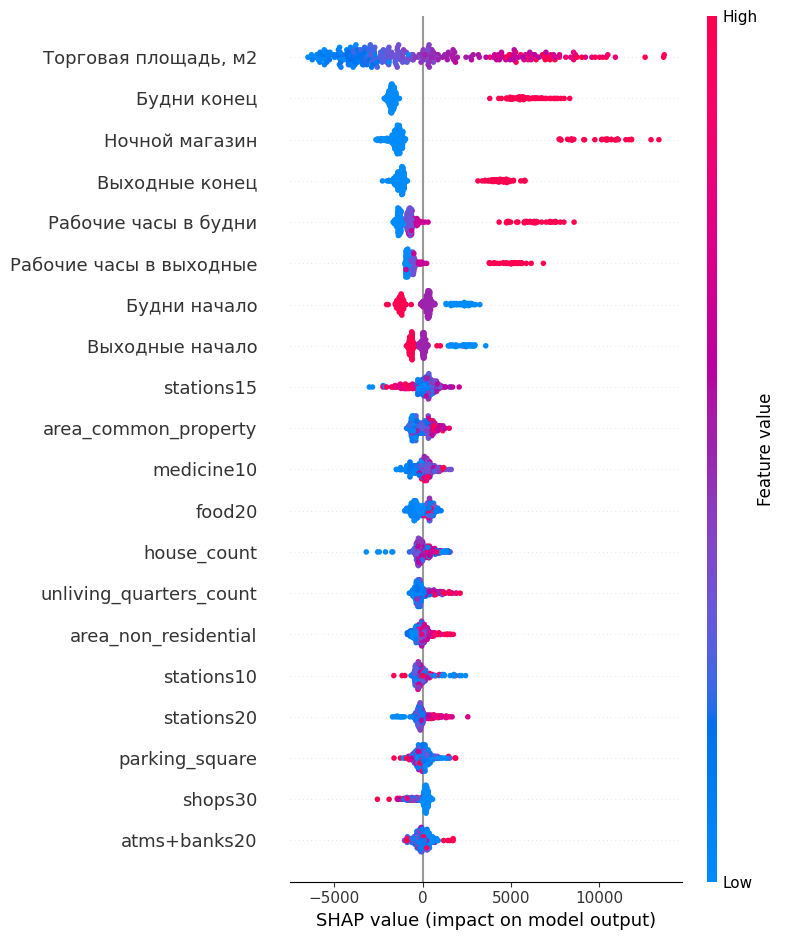

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(all_data)

shap.summary_plot(shap_values, all_data)

In [17]:
importance_df = pd.DataFrame({
    "column_name": all_data.columns,
    "shap_values": np.abs(shap_values).mean(0)
})
importance_df.sort_values("shap_values", ascending=False, inplace=True)
importance_df.reset_index(inplace=True, drop=True)

In [26]:
importance_df.loc[:20]

,column_name,shap_values
0,"Торговая площадь, м2",3753.123350
1,Будни конец,2747.975958
2,Ночной магазин,2507.833838
3,Выходные конец,1973.297199
4,Рабочие часы в будни,1618.442232
5,Рабочие часы в выходные,1124.690748
6,Будни начало,943.794754
7,Выходные начало,619.939417
8,stations15,517.749504
9,area_common_property,453.844562


In [20]:
data

,"Торговая площадь, м2",Ночной магазин,Будни начало,Будни конец,Выходные начало,Выходные конец,Разные графики,Рабочие часы в будни,Рабочие часы в выходные,medicine10,stations10,housing10,shops10,atms+banks10,office10,food10,for_motorists10,medicine15,stations15,housing15,shops15,atms+banks15,office15,food15,for_motorists15,medicine20,stations20,housing20,shops20,atms+banks20,...,housing30,shops30,atms+banks30,office30,food30,for_motorists30,dist_to_city_center,dist_to_city_center_car,time_to_city_center_car,time_to_city_center_car_m,p_huff,time_to_highway,dist_to_highway,time_to_highway_m,house_count,built_year,exploitation_start_year,is_alarm,floor_count_max,floor_count_min,entrance_count,quarters_count,living_quarters_count,unliving_quarters_count,area_total,area_residential,area_non_residential,area_common_property,area_land,parking_square
0,52.6,0,9,22,9,22,0,13,13,4,3,0,23,1,0,1,1,0,2,0,24,1,0,1,2,8,4,1,59,0,...,0,0,0,0,0,0,1.550430,3.3308,363.0,6.050000,1.437060,236.6,2.0915,3.943333,95,1997.210526,1997.600000,0,7.168421,7.115789,4.052632,126.673684,115.831579,11.157895,7824.184421,5195.029579,668.162105,1530.070526,3848.320421,43.725319
1,78.0,0,9,22,9,22,0,13,13,0,2,0,6,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,2,0,...,0,0,0,0,0,0,4.039671,12.3174,958.3,15.971667,0.305769,123.0,0.8059,2.050000,38,1967.250000,1955.375000,19,1.625000,2.250000,1.625000,3.921053,24.750000,0.000000,1454.254286,799.150000,48.500000,283.950000,780.002500,0.000000
2,73.0,0,8,22,8,22,0,14,14,28,28,4,180,20,22,69,0,27,34,4,123,14,14,57,3,26,23,9,165,14,...,0,0,0,0,0,0,3.216366,5.3261,566.2,9.436667,0.819758,105.7,1.0401,1.761667,279,1956.543071,1901.371841,0,8.309353,5.755639,2.884477,77.566308,78.602996,5.569811,6929.109025,5289.814152,1215.264176,1194.003674,2789.099775,20.974903
3,85.5,0,8,22,8,22,0,14,14,4,5,0,25,3,0,1,0,7,14,1,35,2,4,13,0,18,25,1,130,10,...,0,0,0,0,0,0,1.080211,1.8657,175.6,2.926667,9.982047,403.1,4.6662,6.718333,233,1978.518018,1979.008772,4,9.162281,8.053812,3.600877,142.682403,140.143498,6.013514,10211.506916,7474.212301,450.693036,2504.402941,5245.323486,78.200000
4,100.0,0,8,22,8,22,0,14,14,28,18,1,149,10,11,34,1,10,17,0,46,2,6,13,1,12,6,0,57,7,...,0,0,0,0,0,0,0.926878,2.1810,222.5,3.708333,7.271809,245.0,2.6713,4.083333,99,1980.867347,1981.494949,0,6.727273,6.551020,2.464646,73.787879,63.107692,7.660714,4127.028283,3484.109895,337.934868,1116.074746,7829.426667,26.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,370.0,0,9,22,9,22,0,13,13,14,12,0,56,3,7,6,1,1,7,0,21,2,2,1,1,0,3,0,3,1,...,0,0,0,0,0,0,1.112408,1.1802,112.3,1.871667,105.619647,318.7,4.0320,5.311667,130,1988.500000,1987.763780,0,9.112903,9.863636,2.919355,101.846154,117.118182,1.266055,7466.303150,5572.105763,248.219643,2094.994495,52441.602222,62.433962
294,310.0,0,7,23,7,23,0,16,16,21,9,0,155,17,28,30,0,7,7,0,46,2,3,12,0,0,8,0,6,1,...,0,0,0,0,0,0,0.264406,0.2868,30.3,0.505000,1215.567101,121.4,1.3334,2.023333,151,1978.868056,1978.868966,4,6.779310,6.655172,3.600000,83.132450,85.041379,3.054795,4611.000828,4200.171241,493.538621,1955.029474,4797.435000,85.513869
295,367.7,1,7,23,7,23,0,16,16,12,15,7,84,24,34,30,4,26,43,13,191,42,62,133,1,37,42,11,178,25,...,0,5,0,9,3,0,3.285915,5.1657,568.6,9.476667,4.094326,510.9,5.7396,8.515000,292,1946.337079,1947.055749,0,7.783217,7.209738,2.559441,64.006849,63.188679,2.775665,4944.947308,3798.993887,1058.186087,1479.563132,617492.719925,22.545802
296,371.9,1,7,23,7,23,0,16,16,37,16,1,151,8,6,23,3,13,6,2,66,1,3,15,1,7,4,2,60,3,...,0,3,0,0,0,0,1.618674,2.6016,261.9,4.365000,19.519005,72.0,0.5856,1.200000,108,2005.031250,2005.489796,0,19.734694,15.937500,3.683673,258.842593,285.884211,9.712766,26001.018367,18295.768367,1185.154639,6184.818947,11377.064149,277.433333


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

In [25]:
all_data = pd.concat([data, data_cat], axis=1) 
all_data_with_targets = pd.concat([
    all_data[importance_df.iloc[:20].column_name.tolist()], 
    df_target[["Выручка р/мес", "Чеки шт/мес"]]
    ], axis=1) 

revenue = all_data_with_targets['Выручка р/мес'].values
all_data = all_data_with_targets.drop(columns = ["Выручка р/мес", "Чеки шт/мес"], axis = 1)

model = CatBoostRegressor(logging_level='Silent', random_state=SEED)
transformer = ColumnTransformer(
    [
        (
            "numerical_pipeline",
            Pipeline(steps=[("scaler", MinMaxScaler())]),
            all_data.columns,
        ),
    ]
)
pipeline = Pipeline([("preprocessing_part", transformer), ("model_part", model)])
cv = LeaveOneOut()
score = cross_val_score(pipeline, all_data, revenue, cv=cv, scoring="neg_mean_absolute_percentage_error")
pipeline.fit(all_data, revenue)
revenue_pred = pipeline.predict(all_data)
print('CatBoostRegressor MAPE: %.3f' % -np.mean(score))

CatBoostRegressor MAPE: 0.177


In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(all_data)

for idx, row in tqdm(result.iterrows(), leave=result.shape[0], total=result.shape[0]):
    plt.clf()
    png = f'../../data/fig/{row["Номерточки"]}.png'
    shap.plots.waterfall(shap_values[idx], max_display=80, show=False)
    plt.savefig(png, dpi=100, bbox_inches='tight')

In [1]:
resolution, width, height = 100, 12, 5
m = folium.Map(location=[result["Широта"].mean(), result["Долгота"].mean()], zoom_start=10)
marker_cluster = MarkerCluster().add_to(m)
heat_data = []
for idx, row in tqdm(result.iterrows(), leave=result.shape[0], total=result.shape[0]):
    location = [row["Широта"], row["Долгота"]]
    heat_data.append([row["Широта"], row["Долгота"], row["Предсказание выручки"]])

    png = f'../../data/fig/{row["Номерточки"]}.png'
    encoded = base64.b64encode(open(png, 'rb').read())
    html = '<img src="data:image/png;base64,{}">'.format
    iframe = folium.IFrame(html(encoded.decode('UTF-8')), width=(width*resolution)+20, height=(height*resolution)+20)
    popup = folium.Popup(iframe, max_width=2650)
    
    folium.Marker(
        location,
        popup=popup,
        tooltip=f"""
        <b>{row["Широта"]}</b>, <b>{row["Долгота"]}</b><br>
        <i>Номерточки: </i><b><br>{row['Номерточки']}</b><br>
        <i>Чеки: </i><b><br>{round(row['Чеки шт/мес'], 2)}</b><br>
        <i>Выручка: </i><b><br>{round(row['Выручка р/мес'], 2)}</b><br>
        <i>Предсказание выручки: </i><b><br>{round(row['Предсказание выручки'], 2)}</b><br>""", 
        ).add_to(marker_cluster)
    
HeatMap(heat_data, radius=18, gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}).add_to(m)
colormap = folium.branca.colormap.LinearColormap(['blue', 'lime', 'red'], 
                                          vmin=result['Предсказание выручки'].min(), 
                                          vmax=result['Предсказание выручки'].max(),
                                          caption='Предсказание выручки')
colormap.add_to(m)
m

In [152]:
m.save("result.html")